# Purpose

(1) Make noise spectra of
* Detecotor noise = intrinsic noise = 1/f noise
* Photon noise ... Loop gain
* Phonon noise
* Readout noise =? Johnson noise =? SQUID noise
* Line noise by interference

2) Apply spectral responses by CIC, FIR

3) Make realizations of ToD

4) Apply data compression

# References

- https://kicp-workshops.uchicago.edu/CMB-School/resources/depot/benson__5.pdf
- https://docs.astropy.org/en/stable/api/astropy.units.thermodynamic_temperature.html
- https://docs.google.com/spreadsheets/d/1dFGiC9bydefKYmuOvPHMKjrcmzb1y1pE_7hYDOp_6N4/edit#gid=202837976
- https://docs.google.com/document/d/1b2OJ61hjZT2sx8c4z1fflpAyAFOKKQKVLJnSjoU5Kr0/edit
- https://docs.google.com/presentation/d/1UT7u4qQgJiS_1nJSs9CJuN5LCGBGEyotc40tgNRQqLw/edit?pli=1#slide=id.g88f77050ce_0_47  

In [7]:
# Imports
import numpy as np
import pandas as pd
from astropy import units as u
from astropy import constants as const
h = const.h
c = const.c
k_B = const.k_B
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode(connected=False)
import plotly.express as px
colors=px.colors.qualitative.Plotly
palette=('black','red','blue','green','purple','orange',
         'magenta','cyan','yellow','brown','violet','turquoise')

In [6]:
# Parameter setting
## Frequency range
f_min = 1.0/3600./24 # 1 day
f_max = 20e6/2**11 # CIC1 (2**6), CIC2 (2**5), CIC3 (2**5), FIR (2**3). Start b/w CIC2 and CIC3.
print(f_min, f_max)
# Round the numbers
f_min = 1e-5
f_max = 1e4
fs = np.logspace(-5,4,9*10+1)
ws = fs * 2. * np.pi

1.1574074074074073e-05 9765.625


# Noise database

In [29]:
# Data
# f_knee = 20 mHz, alpha = 1
# TES time constant
tau0=33e-3
tau_eff=3.3e-3

# https://docs.google.com/spreadsheets/d/1dFGiC9bydefKYmuOvPHMKjrcmzb1y1pE_7hYDOp_6N4/edit#gid=202837976
Noise_data_cols=['dname', 'dtype', 'freq', 'PhLoad', 'NEPph', 'NEPg', 'NEPread', 'fknee', 'alpha', 'NEPint', 'NEPext']
Noise_data=[
    ["L1-040", "L1", 40, 0.29184686, 5.44441647, 3.94755931, 2.67399478, 0.02, -1.0, 7.23706732, 4.0939035],
    ["L1-060", "L1", 60, 0.24187821, 5.26100438, 3.59376372, 2.43434099, 0.02, -1.0, 6.82050737, 3.85826161],
    ["L1-078", "L1", 78, 0.26855768, 5.97783229, 3.7867788, 2.5650854, 0.02, -1.0, 7.52687423, 4.25784305],
    ["L2-050", "L2", 50, 0.30598544, 5.71954248, 4.04204858, 2.73799985, 0.02, -1.0, 7.51983817, 4.25386285],
    ["L2-068", "L2", 68, 0.27094372, 5.81005536, 3.80356373, 2.57645516, 0.02, -1.0, 7.40688609, 4.18996751],
    ["L2-089", "L2", 89, 0.2958127, 6.58377923, 3.97429005, 2.69210163, 0.02, -1.0, 8.14791639, 4.60915755],
    ["L3-068", "L3", 68, 0.3278966, 6.57637918, 4.1842691, 2.83433708, 0.02, -1.0, 8.29399407, 4.69179156],
    ["L3-089", "L3", 89, 0.31625242, 6.85404996, 4.10930217, 2.78355604, 0.02, -1.0, 8.46241983, 4.78706756],
    ["L3-119", "L3", 119, 0.37653296, 8.18115868, 4.48386626, 3.03727798, 0.02, -1.0, 9.81129306, 5.55010548],
    ["L4-078", "L4", 78, 0.32719336, 6.75923232, 4.17977967, 2.83129603, 0.02, -1.0, 8.43646945, 4.77238781],
    ["L4-100", "L4", 100, 0.30607807, 6.97036698, 4.04266035, 2.73841425, 0.02, -1.0, 8.51046598, 4.81424656],
    ["L4-140", "L4", 140, 0.35566829, 8.45472357, 4.35786451, 2.95192701, 0.02, -1.0, 9.95927743, 5.63381808],
    ["M1-100", "M1", 100, 0.35588565, 7.61933154, 4.35919591, 2.95282887, 0.02, -1.0, 9.26153338, 5.23911444],
    ["M2-119", "M2", 119, 0.43860747, 8.9189256, 4.83937375, 3.27809138, 0.02, -1.0, 10.66361361, 6.0322508],
    ["M1-140", "M1", 140, 0.42063367, 9.26864051, 4.73917962, 3.21022195, 0.02, -1.0, 10.89371587, 6.16241629],
    ["M2-166", "M2", 166, 0.39077456, 9.55735219, 4.56787585, 3.09418433, 0.02, -1.0, 11.03550848, 6.2426263],
    ["M1-195", "M1", 195, 0.35717258, 9.78367735, 4.36707054, 2.95816298, 0.02, -1.0, 11.1149618, 6.28757189],
    ["H1-195", "H1", 195, 0.62886291, 13.22647082, 5.7946758, 3.92519316, 0.02, -1.0, 14.96412174, 8.46498556],
    ["H2-235", "H2", 235, 0.4708167, 12.31481045, 5.0139163, 3.39632288, 0.02, -1.0, 13.72329851, 7.76306995],
    ["H1-280", "H1", 280, 0.37702823, 11.91261558, 4.48681422, 3.03927487, 0.02, -1.0, 13.08736427, 7.40333122],
    ["H2-337", "H2", 337, 0.2996769, 11.58180607, 4.00016388, 2.70962803, 0.02, -1.0, 12.54916838, 7.09888165],
    ["H3-402", "H3", 402, 0.22026075, 10.84704975, 3.42941234, 2.32301277, 0.02, -1.0, 11.61101829, 6.56818382],
]

Noise_data = pd.DataFrame(Noise_data, columns=Noise_data_cols)
Noise_data['NEPdet'] = Noise_data['NEPint']**2.0 + Noise_data['NEPext']**2.0
Noise_data['NEPdet']= Noise_data['NEPdet'].apply(np.sqrt)
print(Noise_data)

     dname dtype  freq    PhLoad      NEPph      NEPg   NEPread  fknee  alpha  \
0   L1-040    L1    40  0.291847   5.444416  3.947559  2.673995   0.02   -1.0   
1   L1-060    L1    60  0.241878   5.261004  3.593764  2.434341   0.02   -1.0   
2   L1-078    L1    78  0.268558   5.977832  3.786779  2.565085   0.02   -1.0   
3   L2-050    L2    50  0.305985   5.719542  4.042049  2.738000   0.02   -1.0   
4   L2-068    L2    68  0.270944   5.810055  3.803564  2.576455   0.02   -1.0   
5   L2-089    L2    89  0.295813   6.583779  3.974290  2.692102   0.02   -1.0   
6   L3-068    L3    68  0.327897   6.576379  4.184269  2.834337   0.02   -1.0   
7   L3-089    L3    89  0.316252   6.854050  4.109302  2.783556   0.02   -1.0   
8   L3-119    L3   119  0.376533   8.181159  4.483866  3.037278   0.02   -1.0   
9   L4-078    L4    78  0.327193   6.759232  4.179780  2.831296   0.02   -1.0   
10  L4-100    L4   100  0.306078   6.970367  4.042660  2.738414   0.02   -1.0   
11  L4-140    L4   140  0.35

## (1) Internal noise (w. 1/f noise)

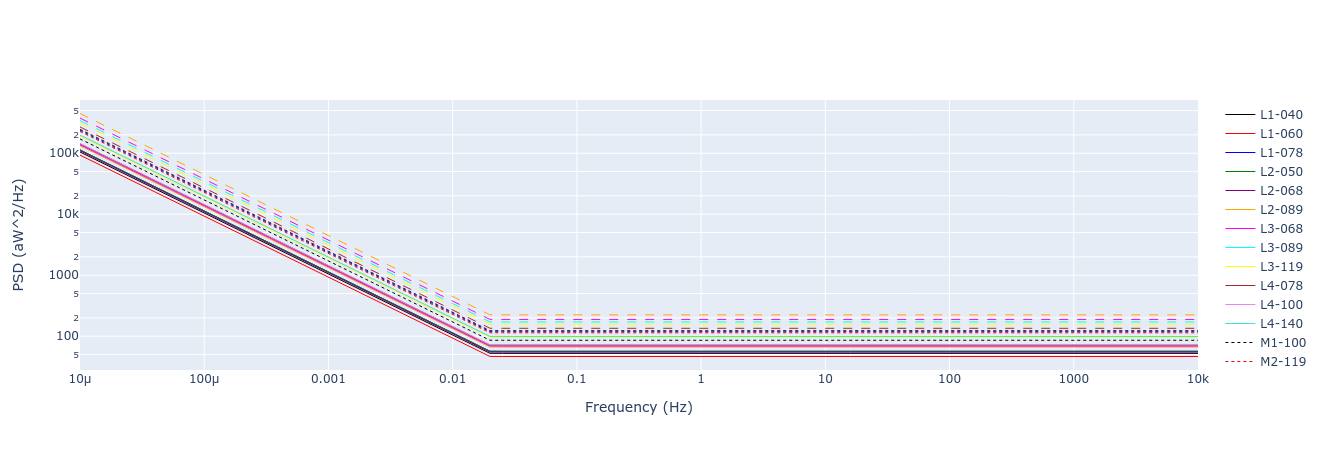

In [16]:
# Model
def psd_int(f, noise_floor, fknee, alpha):
    if (f >= fknee):
        return noise_floor*noise_floor
    else:
        return noise_floor * noise_floor * (f/fknee) ** alpha

# Plot
data=[]
for i, row in Noise_data.iterrows():
    dname = row['dname']
    _color = palette[i%len(palette)]
    if ('L' in dname):
        _dash='solid'
    elif ('M' in dname):
        _dash='dot'
    elif ('H' in dname):
        _dash='dash'
    else:
        _dash=None
        
    NEPint = row['NEPint']
    fknee = row['fknee']
    alpha = row['alpha']
    PSDint = [psd_int(_f, NEPint, fknee, alpha) for _f in fs]
    data.append(go.Scatter(x=fs, y=PSDint, name=dname, line=dict(color=_color, width=1, dash=_dash)))
    
layout = go.Layout(
    title="",
    xaxis={
        "title": "Frequency (Hz)",
        "type" : "log",
    },
    yaxis={
        "title": "PSD (aW^2/Hz)",
        "type" : "log",
    }
)

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig)

## (2) Phonon noise

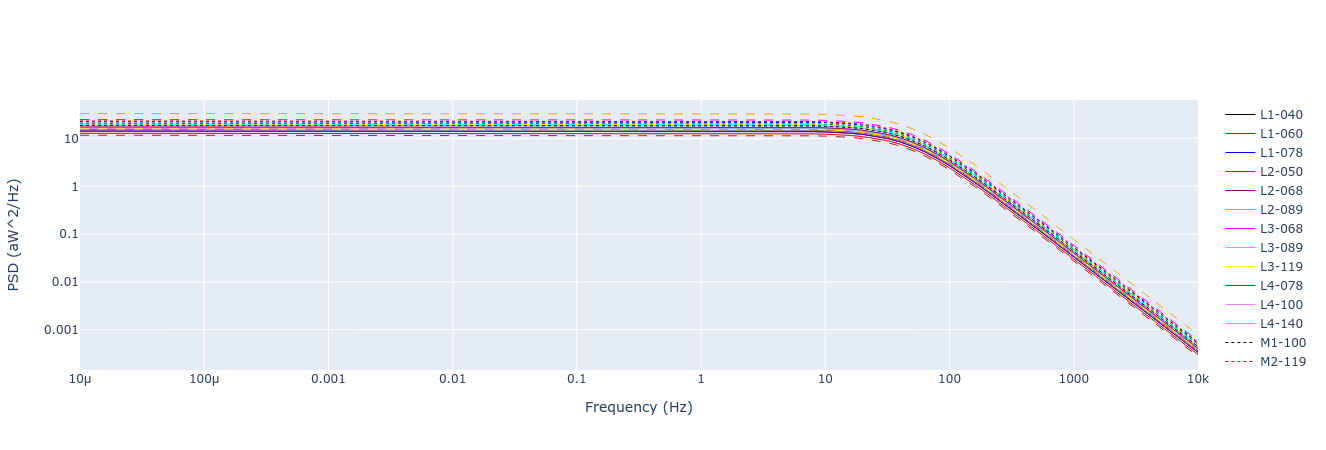

In [18]:
# Model
def psd_g(f, NEPg, tau0, tau_eff):
    w = 2 * np.pi * f
    PSDg = NEPg * NEPg * 1.0/(1+w*w*tau_eff*tau_eff)
    return PSDg

# Plot
data=[]
for i, row in Noise_data.iterrows():
    dname = row['dname']
    _color = palette[i%len(palette)]
    if ('L' in dname):
        _dash='solid'
    elif ('M' in dname):
        _dash='dot'
    elif ('H' in dname):
        _dash='dash'
    else:
        _dash=None
        
    NEPg = row['NEPg']
    PSDg = [psd_g(_f, NEPg, tau0, tau_eff) for _f in fs]
    data.append(go.Scatter(x=fs, y=PSDg, name=dname, line=dict(color=_color, width=1, dash=_dash)))
    
layout = go.Layout(
    title="",
    xaxis={
        "title": "Frequency (Hz)",
        "type" : "log",
    },
    yaxis={
        "title": "PSD (aW^2/Hz)",
        "type" : "log",
    }
)

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig)

## (3) Johnson noise

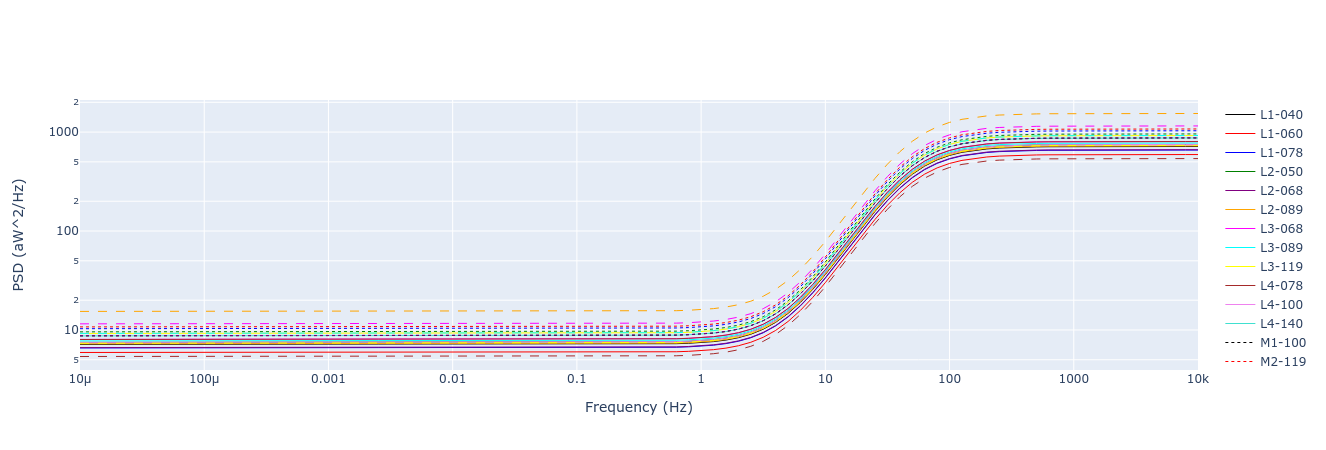

In [22]:
# Model
def psd_read(f, NEPread, tau0, tau_eff):
    w = 2 * np.pi * f
    PSDread = NEPread * NEPread * (1+w*w*tau0*tau0)/(1+w*w*tau_eff*tau_eff)
    return PSDread

# Plot
data=[]
for i, row in Noise_data.iterrows():
    dname = row['dname']
    _color = palette[i%len(palette)]
    if ('L' in dname):
        _dash='solid'
    elif ('M' in dname):
        _dash='dot'
    elif ('H' in dname):
        _dash='dash'
    else:
        _dash=None
        
    NEPread = row['NEPread']
    PSDread = [psd_read(_f, NEPread, tau0, tau_eff) for _f in fs]
    data.append(go.Scatter(x=fs, y=PSDread, name=dname, line=dict(color=_color, width=1, dash=_dash)))
    
layout = go.Layout(
    title="",
    xaxis={
        "title": "Frequency (Hz)",
        "type" : "log",
    },
    yaxis={
        "title": "PSD (aW^2/Hz)",
        "type" : "log",
    }
)

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig)

## (4) Photon noise

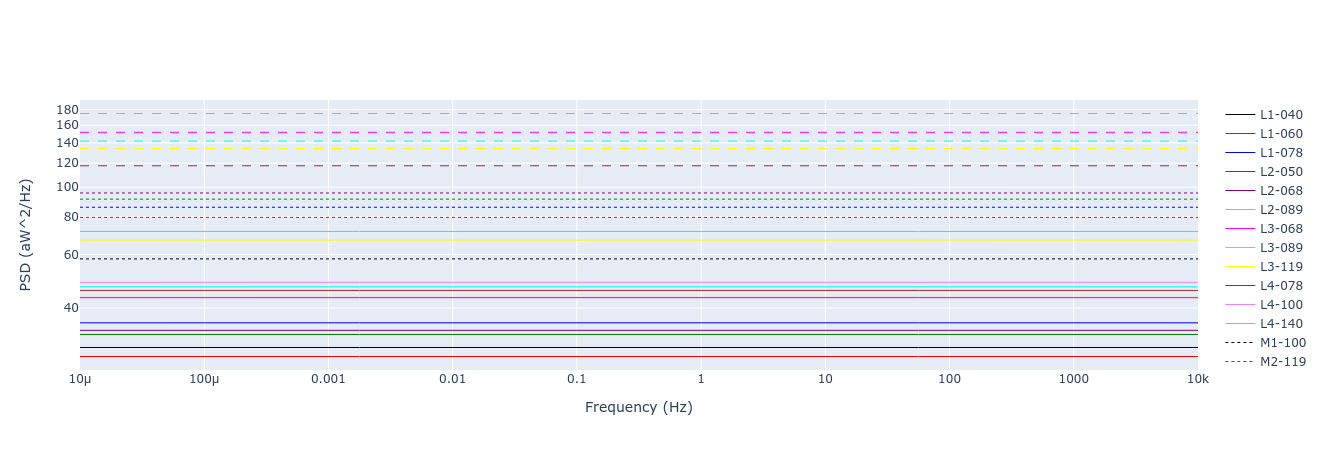

In [27]:
# Model
def psd_ph(f, NEPph):
    return NEPph*NEPph

# Plot
data=[]
for i, row in Noise_data.iterrows():
    dname = row['dname']
    _color = palette[i%len(palette)]
    if ('L' in dname):
        _dash='solid'
    elif ('M' in dname):
        _dash='dot'
    elif ('H' in dname):
        _dash='dash'
    else:
        _dash=None
        
    NEPph = row['NEPph']
    PSDph = [psd_ph(_f, NEPph) for _f in fs]
    data.append(go.Scatter(x=fs, y=PSDph, name=dname, line=dict(color=_color, width=1, dash=_dash)))
    
layout = go.Layout(
    title="",
    xaxis={
        "title": "Frequency (Hz)",
        "type" : "log",
    },
    yaxis={
        "title": "PSD (aW^2/Hz)",
        "type" : "log",
    }
)

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig)

## (5) External noise

In [ ]:
# Model
## Assume the white nature for ext noise. Probably no,
def psd_ext(f, NEPext):
    return NEPext*NEPext

# Plot
data=[]
for i, row in Noise_data.iterrows():
    dname = row['dname']
    _color = palette[i%len(palette)]
    if ('L' in dname):
        _dash='solid'
    elif ('M' in dname):
        _dash='dot'
    elif ('H' in dname):
        _dash='dash'
    else:
        _dash=None
        
    NEPph = row['NEPph']
    PSDph = [psd_ph(_f, NEPph) for _f in fs]
    data.append(go.Scatter(x=fs, y=PSDph, name=dname, line=dict(color=_color, width=1, dash=_dash)))
    
layout = go.Layout(
    title="",
    xaxis={
        "title": "Frequency (Hz)",
        "type" : "log",
    },
    yaxis={
        "title": "PSD (aW^2/Hz)",
        "type" : "log",
    }
)

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig)